In [1]:
from dataclasses import dataclass
import numpy as np
from typing import Tuple, Dict, Callable
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import root
import random as rd
from itertools import product
import pandas as pd
#import statsmodels.api as sm
import scipy.optimize as opt
import scipy.interpolate as interp
from scipy.stats import norm
from numba import jit, njit, int32, float64
import quantecon as qe
from numba.typed import Dict,List
import numba as nb
import time

In [2]:
seed = 123
rd.seed(seed)

In [4]:
n_to_use = 100

In [5]:
f_x_y = pd.read_csv('D:\\panel_fr_res\\calibration\\f_x_y_03_06.csv').dropna()
list_y_table = pd.read_csv('D:\\panel_fr_res\\calibration\\list_y.csv').dropna()
if n_to_use == None:
    n_to_use = len(list_y_table)
else:
    list_y_table = list_y_table.sample(n_to_use)
list_x_table = pd.read_csv('D:\\panel_fr_res\\calibration\\list_x.csv').dropna().sample(n_to_use)


In [6]:
density_private = pd.read_csv('D:\\panel_fr_res\\calibration\\density_03_06_private.csv').dropna()
density_public = pd.read_csv('D:\\panel_fr_res\\calibration\\density_03_06_public.csv').dropna()


In [7]:
pivot_m = f_x_y.pivot(index="x", columns="y", values="z_hat_private")

# 3) Extract sorted grids and matrix
x_grid = pivot_m.index.values.astype(float)   # shape (nx,)
y_grid = pivot_m.columns.values.astype(float) # shape (ny,)
z_m_grid  = pivot_m.values.astype(float)         # shape (nx, ny)

In [8]:
f_x_y

,x,y,z_hat_private,z_hat_public
0,-6.727422,-3.032924,-6.269323,-3.841904
1,-6.594505,-3.032924,-6.193562,-3.815670
2,-6.461587,-3.032924,-6.117899,-3.789436
3,-6.328670,-3.032924,-6.042430,-3.763203
4,-6.195752,-3.032924,-5.967252,-3.736970
...,...,...,...,...
9995,5.899734,6.439021,7.231819,8.695859
9996,6.032651,6.439021,7.287937,8.782572
9997,6.165569,6.439021,7.344406,8.869295
9998,6.298486,6.439021,7.401108,8.956022


In [9]:
pivot_g = f_x_y.pivot(index="x", columns="y", values="z_hat_public")

# 3) Extract sorted grids and matrix
z_g_grid  = pivot_g.values.astype(float)         # shape (nx, ny)

In [10]:
list_x = sorted(list(list_x_table[list_x_table['Period'] == "2003-2006"]['x']))

In [11]:
x_distrib =   (np.sort(list_x))
y_distrib_g = (np.sort(list_y_table[(list_y_table['public']==1 ) & (list_y_table['Period'] == "2003-2006" )]['y'].tolist()))
y_distrib_m = (np.sort(list_y_table[(list_y_table['public']==0 ) & (list_y_table['Period'] == "2003-2006" )]['y'].tolist()))



In [12]:
@njit

def _find_interval(val, grid):
    """
    Find i such that grid[i] <= val <= grid[i+1], clamped to edges.
    Assumes grid is sorted ascending.
    """
    if val <= grid[0]:
        return 0
    n = grid.shape[0]
    if val >= grid[n - 1]:
        return n - 2

    # linear search is OK for small grids; for larger, use np.searchsorted
    # i = np.searchsorted(grid, val) - 1
    # return max(0, min(i, n - 2))
    for i in range(n - 1):
        if grid[i] <= val <= grid[i + 1]:
            return i
    return n - 2

@njit
def _bilinear_interp(x, y, x_grid, y_grid, z_mat):
    i = _find_interval(x, x_grid)
    j = _find_interval(y, y_grid)

    x1, x2 = x_grid[i],     x_grid[i + 1]
    y1, y2 = y_grid[j],     y_grid[j + 1]

    z11 = z_mat[i,     j]
    z21 = z_mat[i + 1, j]
    z12 = z_mat[i,     j + 1]
    z22 = z_mat[i + 1, j + 1]

    tx = 0.0 if x2 == x1 else (x - x1) / (x2 - x1)
    ty = 0.0 if y2 == y1 else (y - y1) / (y2 - y1)

    z1 = z11 * (1 - tx) + z21 * tx
    z2 = z12 * (1 - tx) + z22 * tx
    return z1 * (1 - ty) + z2 * ty

@njit
def predict_z(x, y, x_grid=x_grid, y_grid=y_grid, z_mat = z_g_grid):
    """
    Predict z for given (x, y) using bilinear interpolation on the grid.
    x, y can be scalars or 1D numpy arrays of the same length.
    """
    return _bilinear_interp(x, y, x_grid, y_grid, z_mat)

In [13]:
@njit
def m_u_v(u,v):
    return(scaling_matching  *( u**(0.5)) * (v **0.5))
#@njit
#def d_x_y(x,y):
#    return(1)
@njit
def f(x,y,l):
    if l == 'm':
        return(predict_z(x, y, x_grid, y_grid,z_m_grid))
    if l == 'g':
        return(predict_z(x, y, x_grid, y_grid,z_g_grid))


In [14]:
import numpy as np
from numba import types
from numba.experimental import jitclass

# ---- jitclass field spec (all typed) ----
spec = [
    ('gamma',     types.float64),
    ('alpha_m',     types.float64),
    ('x_val',     types.float64[:]),
    ('y_g_val',   types.float64[:]),
    ('y_m_val',   types.float64[:]),
    ('V_e_x_y', types.float64[:, :]),
    ('V_u',       types.float64[:]),
    ('V_p_x_y', types.float64[:, :]),
    ('V_v_y_m',   types.float64[:]),
    ('V_v_y_g',   types.float64[:]),
    ('u',         types.float64),
    ('V',         types.float64),
    ('e',         types.float64),
    ('matches',   types.int64[:, :]),
    ('states_w',  types.int64[:]),
    ('states_f',  types.int64[:]),
    ('d_y',       types.float64[:]),
    ('d_x',       types.float64[:]),
    ('d_xy',      types.float64[:, :]),
    ('n_params',  types.int64)
]

n_params =len(spec)
@jitclass(spec)
class ModelCurrent:
    def __init__(self, gamma, alpha_m, x_distrib, y_distrib_g, y_distrib_m, matches_distrib = None):
        # Ensure contiguous float64 inputs

        # Unpack columns
        self.gamma = gamma
        self.alpha_m = alpha_m
        self.x_val = np.asarray(x_distrib, dtype=np.float64)
        self.y_g_val = np.asarray(y_distrib_g, dtype=np.float64)
        self.y_m_val = np.asarray(y_distrib_m, dtype=np.float64)
        nx  = len(x_distrib)
        nyg = len(y_distrib_g)
        nym = len(y_distrib_m)
        ny = nyg+nym

        
        # ---- Build Cartesian products via tile/repeat (Numba-friendly) ----
        # For "g"

        def cart2mat(a, b):
            na = len(a)
            nb = len(b)
            N  = na * nb
            M  = np.empty((na, nb), np.float64)
            idx = 0
            for i in range(na):
                ai = a[i]
                for j in range(nb):
                    bj = b[j]
                    M[i, j] = np.float64(ai) * np.float64(bj)
            return M

        y_all = np.empty(nyg + nym, dtype=np.float64)
        for i in range(nyg):
            y_all[i] = self.y_g_val[i]
        for j in range(nym):
            y_all[nyg + j] = self.y_m_val[j]
        self.V_e_x_y = cart2mat(self.x_val, y_all)
        self.V_p_x_y = cart2mat(self.x_val, y_all)
        ##model.V_u: [x_value, 0.5]
        self.V_u = np.full(nx, np.float64(0))

        ## V_v_y_*
        self.V_v_y_g = np.full(nyg, np.float64(0))
        self.V_v_y_m = np.full(nym, np.float64(0))

        ## Scalars
        self.u = np.float64(0)
        self.V = np.float64(0.2)
        self.e = np.float64(1)

        ## 
        initial_distrib = np.random.permutation(min(nx, ny))  # Permute up to the smallest length
        matches = np.zeros((nx, ny), dtype=np.int64)
        
        for x in range(len(initial_distrib)):
            matches[x, initial_distrib[x]] = 1        
        self.matches = matches
        self.states_w = np.full(nx,np.int64(1))
        self.states_f = np.full(nyg+nym, np.int64(1))
        #

        ## distribution of matches :
        if matches_distrib is not None:
            self.d_xy = matches_distrib
        else:
            self.d_xy = matches/np.sum(matches)
        ## d_y: 
        self.d_y = np.full(nyg + nym, np.float64(0))

        ## d_x: 
        self.d_x = np.full(nx, np.float64(0))

        self.n_params = np.int64(n_params)


In [15]:
@njit
def w_x_y(x,y,l, model):
    if l == 'm':
        V_t = model.V_e_x_y[x,y]
        x_val = model.x_val[x]
        y_val = model.y_m_val[y-nyg]
        
        M_e = phi* m_u_v(model.u+ phi* model.e, model.V)/(model.u + phi * model.e)
    
        potential_jobs_g = [ model.V_e_x_y[x,y_prime] *model.d_y[y_prime]
                                         for y_prime in range(0, nyg) 
                            if model.V_e_x_y[x,y_prime] > V_t
                            and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
        int_g = [model.d_y[y_prime]
                                         for y_prime in range(0, nyg) 
                 if model.V_e_x_y[x,y_prime] > V_t
                 and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
        
        potential_jobs_m =[ model.V_e_x_y[x,nyg+y_prime] *model.d_y[nyg+y_prime]
                                         for y_prime in range(0, nym) 
                           if model.V_e_x_y[x,nyg+y_prime] >  V_t
                           and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]
        int_m = [ model.d_y[nyg+y_prime]
                                         for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] > V_t
                                        and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]

        sum_potential_jobs = beta * (1 - delta) * M_e * \
                              (lambda_g  *( sum(potential_jobs_g) - sum(int_g)  * model.V_u[x] ) \
                               + lambda_m *( sum(potential_jobs_m) - sum(int_m)  * model.V_u[x] ) ) 
        w= (model.alpha_m - (1- model.alpha_m) * model.gamma) * f(x_val,y_val,'m') - \
            model.alpha_m * (1-beta) *model.V_v_y_m[y-nyg] + \
            ( 1 - model.alpha_m ) * (1 - beta) * model.V_u[x] \
            - (1- model.alpha_m) * sum_potential_jobs
        
        return(w )
    
    if l == 'g':
        return(  1 )


In [16]:
@njit
def new_V_u_x(x,model):
    """
    Update value function for unemployed people at time t
    """
    M_u = m_u_v(model.u+ phi* model.e, model.V)/(model.u + phi * model.e)
    
    potential_jobs_g = [ model.V_e_x_y[x,y] *model.d_y[y]
                                     for y in range(0, nyg) if model.V_e_x_y[x,y] > model.V_u[x]
                                    and model.V_p_x_y[x,y] > model.V_v_y_g[y] ]
    int_g = [ model.d_y[y] 
                                     for y in range(0, nyg) if model.V_e_x_y[x,y] > model.V_u[x]
                                    and model.V_p_x_y[x,y] > model.V_v_y_g[y] ]
    
    potential_jobs_m = [ model.V_e_x_y[x,nyg+y] *model.d_y[nyg+y] 
                                     for y in range(0, nym) if model.V_e_x_y[x,nyg+y] > model.V_u[x]
                                    and model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] ]
    
    int_m = [ model.d_y[nyg+ y] 
                                     for y in range(0, nym) if model.V_e_x_y[x,nyg+y] > model.V_u[x]
                                    and model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] ]

    V = (1/(1-beta*(1-M_u)*(1-delta)*(lambda_g * sum(int_g) + lambda_m * sum(int_m) ))) *( 
                    beta*(1-delta) *M_u * (lambda_g * sum(potential_jobs_g) + lambda_m * sum(potential_jobs_m)))
    return(V)


In [17]:
##### new value function for employed_public
@njit
def new_V_e_x_y(x, y, model, debug= False):
    """
    Update value function for employed people at time t going into sector g
    """
    if y <nyg:
        sector = 'g'
        y_val = model.y_g_val[y]
    else:
        sector = 'm'
        y_val = model.y_m_val[y-nyg]

        
    V_t = model.V_e_x_y[x,y]
    M_e = phi* m_u_v(model.u+ phi* model.e, model.V)/(model.u + phi * model.e)

    
    potential_jobs_g = [ model.V_e_x_y[x,y_prime] *model.d_y[y_prime]
                                     for y_prime in range(0, nyg) if model.V_e_x_y[x,y_prime] > V_t
                                    and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
    int_g = [model.d_y[y_prime]
                                     for y_prime in range(0, nyg) if model.V_e_x_y[x,y_prime] > V_t
                                    and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
    potential_jobs_m =[ model.V_e_x_y[x,nyg+y_prime] *model.d_y[nyg + y_prime]
                                     for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] >  V_t
                                    and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]
    int_m = [ model.d_y[nyg + y_prime]
                                     for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] > V_t
                                    and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]

    denom = 1 - beta * (1-delta ) * (1 - M_e * (lambda_g * sum(int_g) + lambda_m * sum(int_m) ) )
    
    flux = model.gamma * f(model.x_val[x],y_val,sector) + w_x_y(x,y,sector,model) + beta * delta * model.V_u[x] 
    
    potential_jobs = beta * (1-delta) * M_e * (lambda_g * sum(potential_jobs_g) + lambda_m * sum(potential_jobs_m) )
    
    V = (flux + potential_jobs)/denom
    
    if debug == True:
        print(flux)
        print(model.gamma )
        print(denom)
        print(potential_jobs)
    return(V)


In [18]:
@njit
def new_V_v_y_g(y,model):
    """
    
    """
    if model.V !=0:
        M_v = m_u_v( model.u /+ phi* model.e, model.V)/(model.V)
    else:
        M_v = 0

    
    M_v = m_u_v( model.u /+ phi* model.e, model.V)/(model.V)
    C_u = model.u / (model.u + phi * model.e ) 
    C_e = phi * model.e / (model.u + phi * model.e ) 


    ### matching with employed!:
    potential_unemployed = 0
    int_unemployed = 0
    potential_employed_g = 0
    int_employed_g = 0
    potential_employed_m = 0
    int_employed_m = 0

    for x in range(0, nx):
        if model.V_p_x_y[x,y] > model.V_v_y_g[y] and model.V_e_x_y[x,y] > model.V_u[x] :
            potential_unemployed = potential_unemployed +  model.V_e_x_y[x,y] *model.d_x[x]
            int_unemployed = int_unemployed +  model.d_x[x]
        for y_prime in range(0, nyg):
            if  model.V_p_x_y[x,y] > model.V_v_y_g[y] and model.V_e_x_y[x,y] > model.V_e_x_y[x,y_prime]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,y] *model.d_xy[x,y_prime]
                int_employed_g = int_employed_g + model.d_xy[x,y_prime]
        for y_prime in range(0, nym):
            if  model.V_p_x_y[x,y] > model.V_v_y_g[y] and model.V_e_x_y[x,y] > model.V_e_x_y[x,nyg+y_prime]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,y] *model.d_xy[x,nyg+y_prime]
                int_employed_m = int_employed_m + model.d_xy[x,nyg+y_prime]


    denom = 1/ ( 1 - beta * ( 1 - (1 - delta) * M_v * ( C_u * int_unemployed + C_e * ( lambda_g * int_employed_g + lambda_m * int_employed_m ))))
    num = beta * ( 1 - delta ) * M_v * ( C_u * potential_unemployed + C_e * ( lambda_g * potential_employed_g  + lambda_m * potential_employed_m  ) )
    V = num/denom
    return(V)


In [19]:
@njit
def new_V_v_y_m(y,model):
    """
    
    """
    if model.V !=0:
        M_v = m_u_v( model.u /+ phi* model.e, model.V)/(model.V)
    else:
        M_v = 0
    C_u = model.u / (model.u + phi * model.e ) 
    C_e = phi * model.e / (model.u + phi * model.e ) 


    ### matching with employed!:
    potential_unemployed = 0
    int_unemployed = 0
    potential_employed_g = 0
    int_employed_g = 0
    potential_employed_m = 0
    int_employed_m = 0

    for x in range(0, nx):
        if model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] and model.V_e_x_y[x,nyg+y] > model.V_u[x] :
            potential_unemployed = potential_unemployed +  model.V_e_x_y[x,nyg+y] *model.d_x[x]
            int_unemployed = int_unemployed +  model.d_x[x]
        for y_prime in range(0, nyg):
            if  model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] and model.V_e_x_y[x,nyg+y] > model.V_e_x_y[x,y_prime]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,nyg+y] *model.d_xy[x,y_prime]
                int_employed_g = int_employed_g + model.d_xy[x,y_prime]
        for y_prime in range(0, nym):
            if  model.V_p_x_y[x,nyg+y] > model.V_v_y_m[y] and model.V_e_x_y[x,nyg+y] > model.V_e_x_y[x,nyg+y_prime]:
                potential_employed_g = potential_employed_g + model.V_e_x_y[x,nyg+y] *model.d_xy[x,nyg+y_prime]
                int_employed_m = int_employed_m + model.d_xy[x,nyg+y_prime]


    denom = 1/ ( 1 - beta * ( 1 - (1 - delta) * M_v * ( C_u * int_unemployed + C_e * ( lambda_g * int_employed_g + lambda_m * int_employed_m ))))
    num = beta * ( 1 - delta ) * M_v * ( C_u * potential_unemployed + C_e * ( lambda_g * potential_employed_g  + lambda_m * potential_employed_m  ) )
    V = num/denom
    
    return(V)


In [20]:
##### new value function for employer
@njit
def new_V_p_x_y(x, y, model, debug = False):
    """
    Update value function for employers at time t
    """
    if y <nyg:
        sector = 'g'
        y_val = model.y_g_val[y]
        V_v =  model.V_v_y_g[y] 
        
    else:
        sector = 'm'
        y_val = model.y_m_val[y-nyg]
        V_v =  model.V_v_y_m[y-nyg] 
        
    V_e_t = model.V_e_x_y[x,y]
    M_e = phi* m_u_v(model.u+ phi* model.e, model.V)/(model.u + phi * model.e)

    int_g = [model.d_y[y_prime]
                                     for y_prime in range(0, nyg) if model.V_e_x_y[x,y_prime] > V_e_t
                                    and model.V_p_x_y[x,y_prime] > model.V_v_y_g[y_prime] ]
    int_m = [ model.d_y[nyg+y_prime]
                                     for y_prime in range(0, nym) if model.V_e_x_y[x,nyg+y_prime] > V_e_t
                                    and model.V_p_x_y[x,nyg+y_prime] > model.V_v_y_m[y_prime] ]

    denom = 1 - beta * (1-delta ) * (1 - M_e * ( 1-  lambda_g * sum(int_g) - lambda_m * sum(int_m) ) )
    
    flux = f(model.x_val[x],y_val,sector) - w_x_y(x,y,sector, model) \
           + beta * delta *( 1 - M_e * ( 1-  lambda_g * sum(int_g) - lambda_m * sum(int_m) ) )   * V_v
    
    V = ( flux ) / denom
    
    if debug == True:
        print((1 - M_e * ( 1-  lambda_g * sum(int_g) - lambda_m * sum(int_m) ) ))
        print(denom)
        print(flux)
        print(sum(int_g))
        print(int_m)
        
    return(V)


In [21]:
@njit
def movement(model, debug = False):
    """
    Define movement at each period
    """
    
    ### Variables for debug
    if debug == True:
        lost_matches = 0
        matches_unemp = 0
        matches_emp = 0

    ### First round : jobs exogeneously disappear
    
    for x in range(0,nx):
        
        for y in range(0, nyg+nym):
            
            if model.matches[x,y] ==1:

                # Pick new status (matched or unmatched), with probability delta of being 0 and 1-delta of being 1
                new_status = np.float64(np.searchsorted(np.cumsum(np.asarray([delta, 1-delta], dtype = np.float64)), np.random.rand(1))[0])
                
                model.matches[x,y] = new_status

                # If new status is 0 (unmatched), suppress the match from the current distribution
                
                if new_status == 0:
                    #set density in unmatched to 1
                    model.d_x[x] = np.float64(1)
                    model.d_y[y] = np.float64(1)

                    # set density in matches to 0
                    model.matches[x,y] = 0
                    
                    if debug == True:
                        lost_matches +=1

    if debug == True:
        print(f'Lost matches: {lost_matches}')

    # Normalize density of matches
    model.d_x = np.asarray([np.ceil(x) for x in model.d_x], dtype = np.float64)
    if np.sum(model.d_x) >0:
        model.d_x = model.d_x/np.sum(model.d_x)
        
    model.d_y = np.asarray([np.ceil(x) for x in model.d_y], dtype = np.float64)
    if np.sum(model.d_y) > 0:
        model.d_y = model.d_y/np.sum(model.d_y)
    
    #### Update states
    
    new_e = np.mean(np.sum(model.matches, axis = 0))
    new_u = 1-new_e
    new_V = 1-np.mean(np.sum(model.matches, axis = 1))
    model.e = new_e
    model.u = new_u
    model.V = new_V
    new_s = phi * new_e + new_u

    
    #### Update value functions for unmatched agents
    
    for x in range(0, nx):
        model.V_u[x] = new_V_u_x(x, model)
        
    for y in range(0,nym):
        model.V_v_y_m[y] = new_V_v_y_m(y, model)
        
    for y in range(0,nyg):
        model.V_v_y_g[y] = new_V_v_y_g(y, model)

    if debug == True:
        print('Unmatched agent value functions updated')
        print(m_u_v(new_u,new_V))
        
    ### Second round : matches from unemployment occur

    # random meeting of unmatched agents 
    unmatched_w =   np.asarray([x for x in range(0, nx) if model.d_x[x] >0]  , dtype = np.int64)
    unmatched_f_g = np.asarray([y for y in range(0, nyg) if model.d_y[y] >0], dtype = np.int64)
    unmatched_f_m = np.asarray([y for y in range(nyg, nym+nyg) if model.d_y[y] >0], dtype = np.int64)
    n_unmatched_w = unmatched_w.shape[0]
    n_unmatched_f = unmatched_f_g.shape[0] + unmatched_f_m.shape[0]

    if debug == True:
        print(f'{n_unmatched_w} workers and {n_unmatched_f} firms to match.')

    
    if n_unmatched_w >0 and n_unmatched_f >0:
        
        for x in unmatched_w:
            
            matched = 0

            # Pick whether they meet with probability 1-M_u of no meeting and M_u of being matching 
            meet = np.searchsorted(np.cumsum(np.asarray([1-m_u_v(new_u,new_V)/new_s,  m_u_v(new_u,new_V)/new_s  ], dtype = np.float64)), np.random.rand(1))[0]
            
            if meet == 1:

                # Pick whether they meet a private or public firm 
                type_meet = np.int64(np.searchsorted(np.cumsum(np.asarray([lambda_g,lambda_m], dtype =np.float64) ), np.random.rand(1))[0])

                if type_meet == 0: ## meeting unmatched firm from type g
                    try:
                        y = np.random.choice(unmatched_f_g,1)[0]
                        if matched == 0 and model.V_e_x_y[x,y] >= model.V_u[x] and model.V_p_x_y[x,y]>= model.V_v_y_g[y]:
                            
                            model.matches[x,y] = 1
                            matched = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)
                            if debug == True:
                                matches_unemp +=1
                    except:
                        matched = 0

        
                else:  ## meeting unmatched firm from type m

                    try:
                        y = np.random.choice(unmatched_f_m,1)[0]
                        if matched == 0 and model.V_e_x_y[x,y] >= model.V_u[x] and model.V_p_x_y[x,y]>= model.V_v_y_m[y-nyg]:
                            model.matches[x,y] = 1
                            matched = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)
                            if debug == True:
                                matches_unemp +=1
                                
                    except:
                        matched = 0
    
    if debug == True:
        print(f'New matches from unemployment: {matches_unemp}')


    #Update current values   
    new_e = np.mean(np.sum(model.matches, axis = 0))
    new_u = 1-new_e
    new_V = 1-np.mean(np.sum(model.matches, axis = 1))
    model.d_x = np.asarray([np.ceil(x) for x in model.d_x], dtype = np.float64)
    if np.sum(model.d_x) !=0:
        model.d_x = model.d_x/np.sum(model.d_x)
    model.d_y = np.asarray([np.ceil(x) for x in model.d_y], dtype = np.float64)
    if np.sum(model.d_y) !=0:
        model.d_y = model.d_y/np.sum(model.d_y)
    model.e = new_e
    model.u = new_u
    model.V = new_V

    # random meeting of matched agents
    # Take all matched workers
    matched_w = np.asarray([x for x in range(0, nx) if model.d_x[x] ==0]  , dtype = np.int64)
    # Get workplace of currently matched workers
    current_match_w =np.argmax(model.matches, axis=1)

    # Update which firms are unmatched from previous step
    unmatched_f_g = np.asarray([y for y in range(0, nyg) if model.d_y[y] >0], dtype = np.int64)
    unmatched_f_m = np.asarray([y for y in range(nyg, nym+nyg) if model.d_y[y] >0], dtype = np.int64)
    n_matched_w = matched_w.shape[0]
    n_unmatched_f = unmatched_f_g.shape[0] + unmatched_f_m.shape[0]

    if debug == True:
        print(f'{n_matched_w} workers and {n_unmatched_f} firms to potentially match.')

    if n_matched_w >0 and n_unmatched_f >0:
        for x in matched_w:
            rematch = 0
            
            # Pick whether they meet with probability 1-M_e of no meeting and M_e of being matching 
            meet = np.searchsorted(np.cumsum(np.asarray([1- phi * m_u_v(new_u,new_V)/new_s, phi * m_u_v(new_u,new_V)/new_s], dtype = np.float64)), np.random.rand(1))[0]
            
            if meet == 1:
                type_meet = np.int64(np.searchsorted(np.cumsum(np.asarray([lambda_g,lambda_m], dtype =np.float64) ), np.random.rand(1))[0])
                # Pick whether they meet a private or public firm 

                if type_meet == 0:
                    try:
                        y = np.random.choice(unmatched_f_g,1)[0]
                        if rematch == 0 and model.d_y[y] != 0 and model.V_e_x_y[x,current_match_w[x]] <= model.V_e_x_y[x,y] and model.V_p_x_y[x,y] >= model.V_v_y_g[y]:

                            # Update new match
                            rematch = 1
                            model.matches[x,y] = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)

                            #Update old match
                            model.matches[x,current_match_w[x]] = 0
                            model.d_y[current_match_w[x]] = np.float64(1)
                            if debug == True:
                                matches_emp +=1
                    except:
                        rematch = 0
        
                else:
                    try:
                        y = np.random.choice(unmatched_f_m,1)[0]
                        if rematch == 0 and model.d_y[y] != 0 and model.V_e_x_y[x,current_match_w[x]] <= model.V_e_x_y[x,y] and model.V_p_x_y[x,y] >= model.V_v_y_m[y-nyg]:
                            
                            # Update new match
                            rematch = 1
                            model.matches[x,y] = 1
                            model.d_x[x] = np.float64(0)
                            model.d_y[y] = np.float64(0)

                            #Update old match
                            model.matches[x,current_match_w[x]] = 0
                            model.d_y[current_match_w[x]] = np.float64(1)
                            if debug == True:
                                matches_emp +=1
                    except:
                        rematch = 0

    if debug == True:
        print(f'New matches from employment: {matches_emp}')

    # Normalize densities
    model.d_x = np.asarray([np.ceil(x) for x in model.d_x], dtype = np.float64)
    if np.sum(model.d_x) !=0:
        model.d_x = model.d_x/np.sum(model.d_x)
    model.d_y = np.asarray([np.ceil(x) for x in model.d_y], dtype = np.float64)
    if np.sum(model.d_y) !=0:
        model.d_y = model.d_y/np.sum(model.d_y)

    #Normalize match density
    model.d_xy = model.matches/np.sum(model.matches)


    model.e = np.mean(np.sum(model.matches, axis = 0))
    model.u = 1-new_e
    model.V = 1-np.mean(np.sum(model.matches, axis = 1))


    ### Recompute value functions for matched agents
    for x in range(0,nx):
        for y in range(0, nyg+nym):
            model.V_e_x_y[x,y] = new_V_e_x_y(x,y,model)
            model.V_p_x_y[x,y] = new_V_p_x_y(x,y,model)
    

    return('ok')
    

In [25]:
def convergence(model,
                max_iter = 10000,
                batch_size = 100,
                threshold = 0.0001,
                verbose = True):
    """
    Define movement at each period
    """
    start_time_global = time.time()
    diff= threshold*1000
    all_seq = []
    i = 0
    while diff > threshold and i <= int(np.floor(max_iter/batch_size)):
        if verbose==True:
            print(f"Batch {str(i+1)}/{str(int(np.floor(max_iter/batch_size)))}. Current diff at {diff}. Elapsed_time : {round((time.time() - start_time_global) / 60, 2)} min. " )
            
        for j in range(i*batch_size, (i+1)*batch_size):
            #print(j)
            movement(model, debug = False)
            current_V_u_x =   np.copy(model.V_u)
            current_V_e_x_y = np.copy(model.V_e_x_y)
            current_V_p_x_y = np.copy(model.V_p_x_y)
            current_V_v_y_g = np.copy(model.V_v_y_g)
            current_V_v_y_m = np.copy(model.V_v_y_m)
            current_matches = np.copy(model.matches)
            
            current_e = np.copy(model.e)
            current_V = np.copy(model.V)
            current_u = np.copy(model.u)
            row_seq ={ 'e' : current_e
                      ,'V' : current_V
                      ,'u' : current_u
                      ,'V_u' : current_V_u_x
                      ,'V_e_x_y' : current_V_e_x_y
                      ,'V_p_x_y' : current_V_p_x_y
                      ,'V_v_y_g' : current_V_v_y_g
                      ,'V_v_y_m' : current_V_v_y_m
                      ,'matches' : current_matches
                      }
            all_seq.append(row_seq)
        if i>0:
            new_avg_e = np.mean([all_seq[idx]['e'] for idx in range(i*batch_size, (i+1)*batch_size)])
            past_e = np.mean([all_seq[idx]['e'] for idx in range((i-1)*batch_size, i*batch_size)])
            diff = abs(past_e-new_avg_e)
        i = i+1
    if i > (int(np.floor(max_iter/batch_size))):
        print('No convergence')
    else:
        print(f'Convergence in {len(all_seq)} steps.') 

    to_return = {"sequences": all_seq,
                 "diff" : diff, 
                 'time': time.time()-start_time_global }
    return(to_return)

In [26]:
########### Parameters

beta = 0.992
delta = 0.01
phi = 0.5
nx = len(list_x)
ny = len(y_distrib_g)+len(y_distrib_m)
nyg = len(y_distrib_g)
nym = len(y_distrib_m)
lambda_g = nyg/ny
lambda_m = 1- lambda_g

scaling_matching = 0.5

In [27]:
grid_size =20

gamma_grid = [i/grid_size for i in range(0,grid_size+1)]
alpha_grid = [i/grid_size for i in range(0,grid_size+1)]

In [29]:
list_convergence = []
start_time = time.time()
for gamma_val, alpha_val in product(gamma_grid, alpha_grid):
    current_model = ModelCurrent(gamma_val, alpha_val, x_distrib,y_distrib_g,y_distrib_m)
    convergence_obj = convergence(current_model, threshold = 0.001, verbose = False)
    list_convergence.append( {"gamma": gamma_val,
                              "alpha_m": alpha_val,
                          "convergence" : convergence_obj})
    print(time.time()-start_time)
optimisation_time = time.time()-start_time

Convergence in 300 steps.
1.6534819602966309
Convergence in 400 steps.
3.731106758117676
Convergence in 500 steps.
6.309911012649536
Convergence in 3200 steps.
23.312135934829712
Convergence in 1900 steps.
33.42073059082031
Convergence in 600 steps.
36.536542892456055
Convergence in 1100 steps.
42.32776951789856
Convergence in 1300 steps.
49.672547340393066
Convergence in 1400 steps.
57.074387550354004
Convergence in 400 steps.
59.36058974266052
Convergence in 500 steps.
62.19804549217224
Convergence in 1000 steps.
67.72831678390503
Convergence in 1600 steps.
76.37222480773926
Convergence in 1200 steps.
82.30793118476868
Convergence in 1800 steps.
91.11619973182678
Convergence in 600 steps.
94.07178401947021
Convergence in 300 steps.
95.58211064338684
Convergence in 600 steps.
98.5912435054779
Convergence in 1100 steps.
103.97724151611328
Convergence in 1100 steps.
109.44361400604248
Convergence in 800 steps.
112.70519137382507
Convergence in 300 steps.
114.48826026916504
Convergence i

In [30]:
x_grid = np.linspace(current_model.x_val.min(), current_model.x_val.max(), 100)
y_grid_pub = np.linspace(current_model.y_g_val.min(), current_model.y_g_val.max(), 100)
y_grid_private = np.linspace(current_model.y_m_val.min(), current_model.y_m_val.max(), 100)
from scipy.interpolate import RegularGridInterpolator
def ssq(p, q):
    return np.sum(np.abs(p - q)**2)


In [31]:
divergence_measures = []
for convergence_obj in list_convergence:
    converged = convergence_obj['convergence']

    # Get density of matches
    matches_converged = [row['matches'] for row in converged['sequences']]
    density_public_gen = np.mean([i[:,:nyg] for i in matches_converged], axis =0)
    density_private_gen = np.mean([i[:,nyg:ny] for i in matches_converged], axis =0)

    # Normalize distrbutions of simulated public and private matches on the same grid as the estimated one
    interp = RegularGridInterpolator((current_model.x_val, current_model.y_g_val), density_public_gen, method="linear",
                                 bounds_error=False, fill_value=0.0)
    Xn, Yn = np.meshgrid(x_grid, y_grid_pub)
    pts_new = np.column_stack([Yn.ravel(), Xn.ravel()])  # (y,x)
    density_public_gen_norm = interp(pts_new).reshape(100, 100)

    interp = RegularGridInterpolator((current_model.x_val, current_model.y_m_val), density_private_gen, method="linear",
                                 bounds_error=False, fill_value=0.0)
    Xn, Yn = np.meshgrid(x_grid, y_grid_private)
    pts_new = np.column_stack([Yn.ravel(), Xn.ravel()])  # (y,x)
    density_private_gen_norm = interp(pts_new).reshape(100, 100)

    divergence_measures.append({"gamma": convergence_obj['gamma'],
                                "alpha" : convergence_obj['alpha_m'],
                                "ssq":( ssq(density_public.pivot(index="y", columns="x", values="density_public").to_numpy(), density_public_gen_norm)+
                                ssq(density_private.pivot(index="y", columns="x", values="density_private").to_numpy(), density_private_gen_norm) ),
                                }
                              )

    

In [32]:
divergence_measures_pd = pd.DataFrame(divergence_measures)

<Axes: xlabel='gamma', ylabel='ssq'>

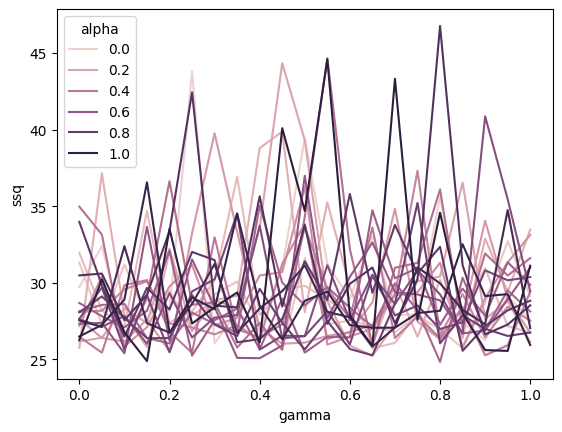

In [33]:
import seaborn as sns

sns.lineplot(divergence_measures_pd, x = "gamma", y= "ssq", hue = "alpha")

In [42]:
len(set(y_grid_pub))

100

In [41]:
V_v_y_m_simul = [row['V_v_y_m'] for row in all_seq]

In [42]:
[np.mean(V_v_y_m) for V_v_y_m in V_v_y_m_simul].index(0)

ValueError: 0 is not in list

In [ ]:
plt.plot([i for i in range(len(all_seq))], [all_seq[i]['e'] for i in range(len(all_seq))])
plt.plot([i for i in range(len(all_seq))], [all_seq[i]['V'] for i in range(len(all_seq))])
plt.plot([i for i in range(len(all_seq))], [all_seq[i]['u'] for i in range(len(all_seq))])

In [96]:
x_indices = np.asarray([int(np.where(current_model.matches[x] ==1)[0]) if len(np.where(current_model.matches[x] ==1)[0])==1 else -1 
                        for x in range(0, nx)] )
realised_matches_g = [ [x, x_indices[x]] for x in range(0,nx) if x_indices[x] !=-1 and x_indices[x] < nyg ]
np.corrcoef([x[0] for x in realised_matches_g],[x[1] for x in realised_matches_g])

C:\Users\raphael.wargon\AppData\Local\Temp\ipykernel_34800\3680129238.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_indices = np.asarray([int(np.where(current_model.matches[x] ==1)[0]) if len(np.where(current_model.matches[x] ==1)[0])==1 else -1


array([[1.        , 0.06737866],
       [0.06737866, 1.        ]])

In [97]:
realised_matches_m = [ [x, x_indices[x]] for x in range(0,nx) if x_indices[x] !=-1 and x_indices[x] > nyg ]
np.corrcoef([x[0] for x in realised_matches_m],[x[1] for x in realised_matches_m])

array([[1.        , 0.01589916],
       [0.01589916, 1.        ]])

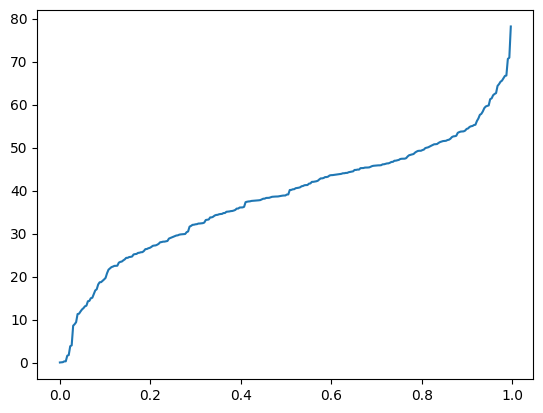

In [98]:
#plt.plot([i for i in range(nx)], [np.mean(V_u_x, axis = 0)[i] for i in range(nx)])
plt.plot([i/nx for i in range(nx)], [
    np.mean([all_seq[j]['V_u'][i] for j in range(len(all_seq))], axis = 0)for i in range(nx)])

In [99]:
x_indices, y_indices = np.where(np.asarray([x[nyg:nyg+nym] for x in current_model.matches] )== 1)
np.corrcoef(x_indices, y_indices)

array([[1.        , 0.00156772],
       [0.00156772, 1.        ]])

In [100]:
np.asarray([x[nyg:nyg+nym] for x in current_model.matches] )

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [101]:
np.mean([all_seq[i]['e'] for i in range(0,len(all_seq))])* delta 

0.0099956

In [102]:
(1 - delta ) * np.mean([all_seq[i]['u'] for i in range(0,len(all_seq))]) * m_u_v(np.mean([all_seq[i]['u'] for i in range(0,len(all_seq))]),
                                                                                     np.mean([all_seq[i]['V']for i in range(0,len(all_seq))]))

3.143272138403152e-06

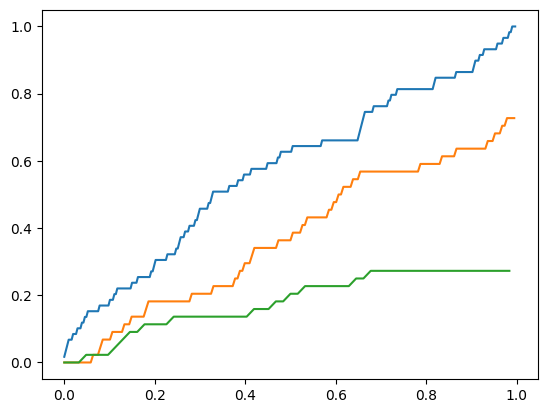

In [103]:
plt.plot([i/len(current_model.d_x) for i in range(len(current_model.d_x))], np.cumsum([current_model.d_x[i] for i in range(len(current_model.d_x))]))
plt.plot([i/nyg for i in range(nyg)], np.cumsum([current_model.d_y[i] for i in range(nyg)]))
plt.plot([i/(nym) for i in range(0,nym)], np.cumsum([current_model.d_y[i] for i in range(nyg,nyg+nym)]))


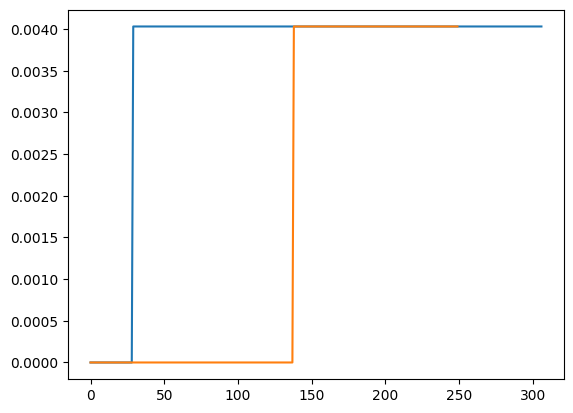

In [104]:
plt.plot([i for i in range(len(current_model.d_x))], np.cumsum([current_model.d_xy[i,90] for i in range(len(current_model.d_x))]))
plt.plot([i for i in range(len(current_model.d_y))], np.cumsum([current_model.d_xy[90,i] for i in range(len(current_model.d_y))]))


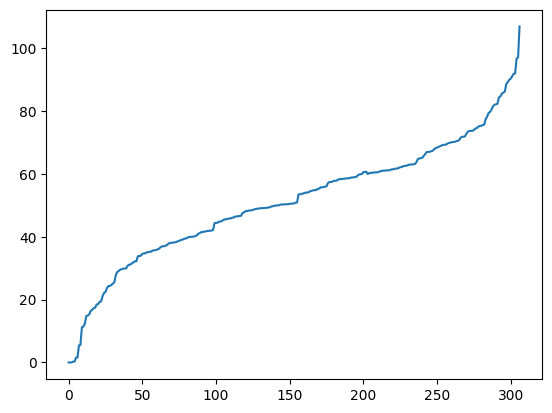

In [105]:
plt.plot([x for x in  range(0,nx)], [current_model.V_u[x] for x in range(0, nx)])

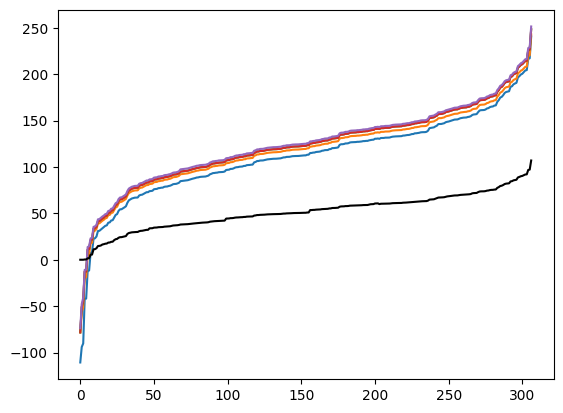

In [106]:
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,0] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,19] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,59] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,60] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,99] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_u[x] for x in range(0, nx)], color= 'black')

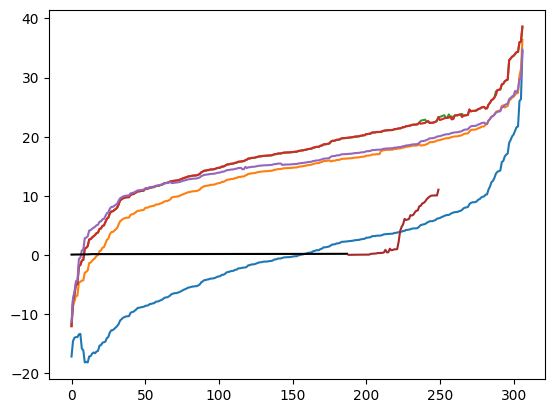

In [107]:
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,0] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,19] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,59] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,60] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,99] for x in range(0, nx)])
plt.plot([x for x in  range(0,nyg)], [current_model.V_v_y_g[x] for x in range(0, nyg)], color = 'black')
plt.plot([x for x in  range(nyg,nyg+nym)], [current_model.V_v_y_m[x] for x in range(0, nym)], color = 'brown')


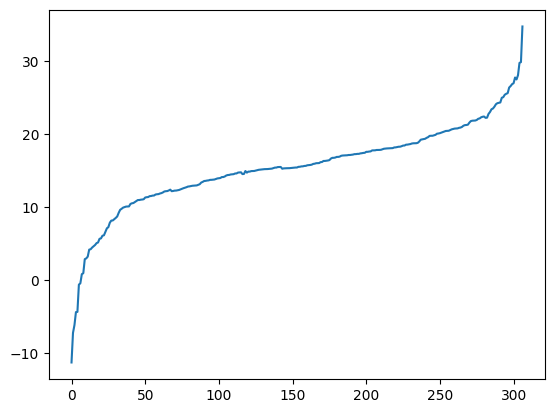

In [108]:
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,99] for x in range(0, nx)])


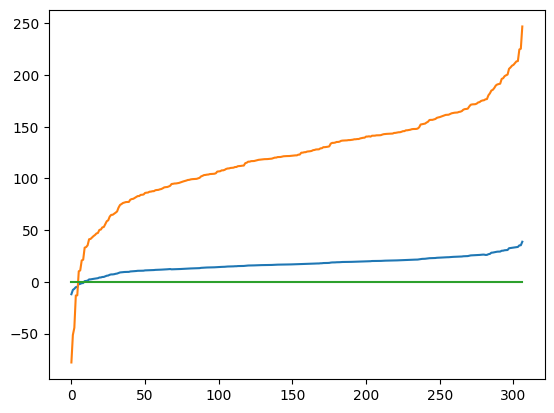

In [109]:
plt.plot([x for x in  range(0,nx)], [current_model.V_p_x_y[x,50] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_e_x_y[x,50] for x in range(0, nx)])
plt.plot([x for x in  range(0,nx)], [current_model.V_v_y_g[50] for x in range(0, nx)])


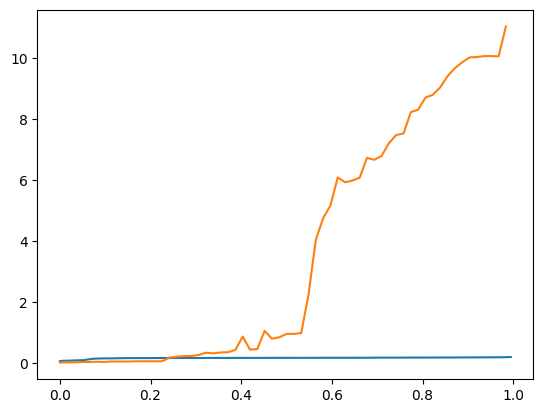

In [110]:
plt.plot([x/nyg for x in  range(0,nyg)], [current_model.V_v_y_g[x] for x in range(0, nyg)])
plt.plot([x/nym for x in  range(0,nym)], [current_model.V_v_y_m[x] for x in range(0, nym)])
